# Langzeit Scheduling

<b> Erkenntnisse: </b>
- Job-Reihenfolge im Solver ist relevant

In [3]:
import json
import random
import numpy as np
import pandas as pd

In [4]:
import pulp

In [5]:
import sys, json
from pathlib import Path

# 1. Projekt-Root nur einmal bestimmen
PROJECT_ROOT = Path.cwd().parent.resolve()

# 2. sys.path fürs Importieren um PROJECT_ROOT erweitern
sys.path.insert(0, str(PROJECT_ROOT))

In [6]:
# Basics
import utils.basics.presenter as show
import utils.basics.converter as convert

import utils.checker as check
import utils.rolling_planning as rp
import utils.schedule_interarrival as sit
import utils.simple.schedule_solver__arrival as ssv

In [7]:
pd.set_option('display.max_rows', 30)

In [8]:
# Datei laden
with open(Path(PROJECT_ROOT,"data/jobshop_instances.json"), "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
df_instance = convert.jssp_dict_to_df(instance)
df_instance

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


In [9]:
df_jssp, df_arrivals_deadlines = rp.init_jobs_with_arrivals(df_instance, 2,  
                                                            u_b_mmax= 0.9,
                                                            generate_deadlines = True,
                                                            deadlines_buffer_factor= 1.75)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
375,Job_037,5,M9,76
376,Job_037,6,M5,47
377,Job_037,7,M3,52
378,Job_037,8,M4,90


In [14]:
df_arrivals_deadlines

,Job,Arrival,Deadline
0,Job_000,0.00,1559.463521
1,Job_001,88.05,2101.534546
2,Job_002,152.78,2395.249063
3,Job_003,207.97,2793.915839
4,Job_004,246.61,1798.177503
...,...,...,...
33,Job_033,2630.89,5216.835839
34,Job_034,2637.28,4188.847503
35,Job_035,2638.72,4881.189063
36,Job_036,2764.04,4323.503521


In [ ]:
# Puffer 1.5 => Deadline = Arrival + k* Bearbeitungszeit * (1.75)  (75% Extra "Bearbeitungszeit" im Schnitt)
k_opt, deadlines = sdead.find_k(jssp_data, df_arrivals, ssv.schedule_fcfs_with_arrivals, target_service=1, buffer_factor = 1.75)
print(f"Gefundener Due-Date-Faktor k = {k_opt:.4f}")

In [16]:

def count_column_grouped(df: pd.DataFrame, column: str = 'Tardiness',
                         bins: list = [-np.inf, 0, 100, 200, 500, np.inf], right_closed: bool = False) -> pd.Series:
    """
    Zählt Werte in definierten Intervallen, trennt Null-Werte explizit und
    erfasst auch negative Werte (<0) separat.

    Parameters:
        df (pd.DataFrame): Input DataFrame
        column (str): Zu gruppierende Spalte
        bins (list): Intervallgrenzen, inkl. -inf und inf
        right_closed (bool): Ob die rechte Grenze inklusiv ist (Standard: linksoffen)

    Returns:
        pd.Series: Gezählte Werte mit Intervall-Indizes,
                   z. B. '<0', '0', '0-100', '100-200', '200-500', '>500'
    """
    # 1. Input-Validierung
    if column not in df.columns:
        raise ValueError(f"Spalte '{column}' existiert nicht. Verfügbare Spalten: {list(df.columns)}")

    # 2. Null-Werte separat zählen
    zero_count = (df[column] == 0).sum()

    # 3. Nur Nicht-Null-Werte für bins
    non_zero = df.loc[df[column] != 0, column]

    # 4. Dynamische Label-Erzeugung aus den Bin-Grenzen
    labels = []
    for lo, hi in zip(bins[:-1], bins[1:]):
        if np.isneginf(lo):
            labels.append('<' + str(int(hi)) if not np.isposinf(hi) else '<inf')
        elif np.isposinf(hi):
            labels.append('>' + str(int(lo)))
        else:
            labels.append(f"{int(lo)}-{int(hi)}")
    # Beispiel: ['<0', '0-100', '100-200', '200-500', '>500']

    # 5. Gruppierung für alle Nicht-Null-Werte
    grouped = pd.cut(non_zero, bins=bins, labels=labels, right=right_closed, include_lowest=True)

    # 6. Zählung pro Intervall
    counts = grouped.value_counts().reindex(labels, fill_value=0)

    # 7. Zero-Wert-Count einfügen
    #    Hier setzen wir das Label '0' zwischen '<0' und '0-100'
    result = pd.concat([
        pd.Series({labels[0]: counts.iloc[0]}),  # '<0'
        pd.Series({'0': zero_count}),
        counts.iloc[1:].rename_axis(None)
    ]).astype(int)

    return result


## 0) FCFS

In [23]:
df_plan_fcfs = ssv.schedule_fcfs_with_arrivals(df_jssp, df_arrivals_deadlines)
df_plan_fcfs

,Job,Operation,Arrival,Machine,Start,Processing Time,End
0,Job_000,0,0.00,M0,0.00,29,29.00
1,Job_000,1,0.00,M1,29.00,78,107.00
3,Job_000,2,0.00,M2,107.00,9,116.00
4,Job_000,3,0.00,M3,116.00,36,152.00
6,Job_000,4,0.00,M4,152.00,49,201.00
...,...,...,...,...,...,...,...
349,Job_037,5,2869.61,M9,3205.89,76,3281.89
354,Job_037,6,2869.61,M5,3281.89,47,3328.89
359,Job_037,7,2869.61,M3,3328.89,52,3380.89
364,Job_037,8,2869.61,M4,3380.89,90,3470.89


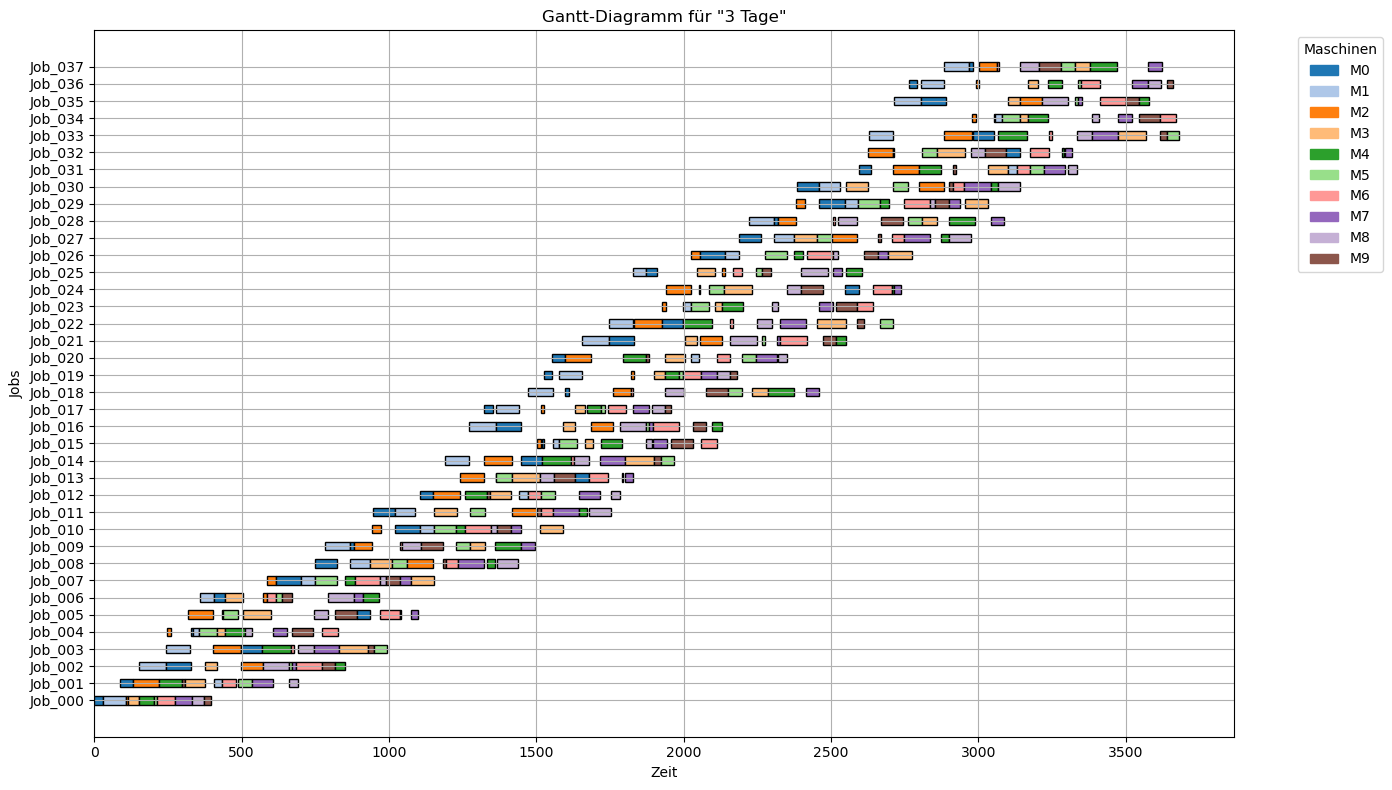

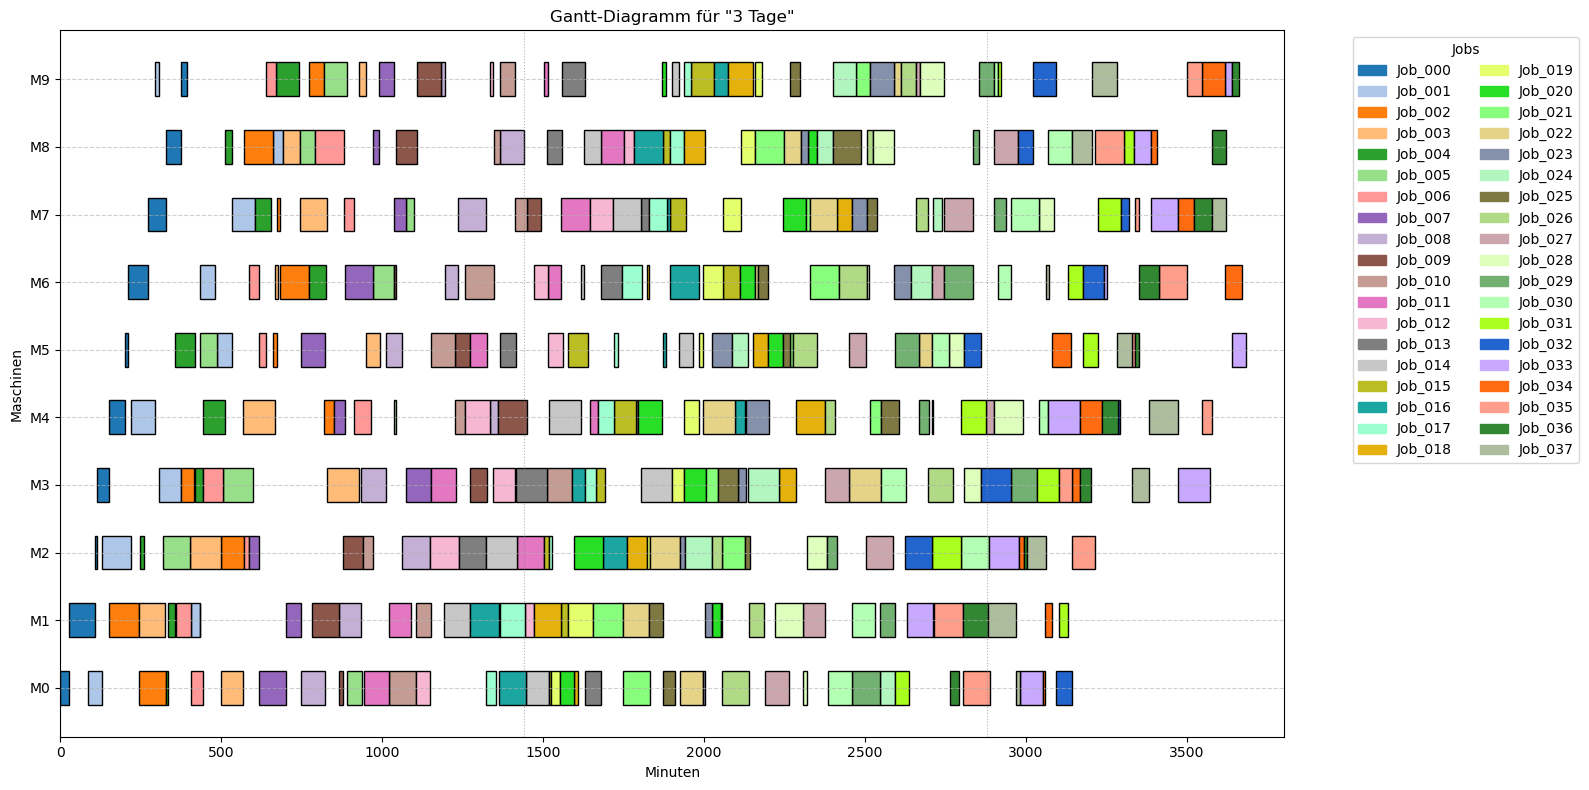

✅ Keine Maschinenkonflikte gefunden
✅ Für alle Jobs ist die Operationssequenz korrekt.
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [27]:
df = df_plan_fcfs
category = "2 Tage"
show.plot_gantt_jobs(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")
show.plot_gantt_machines(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")

check.check_all_constraints(df)

## 1) Tardiness
- Tardiness = 0, wenn der Auftrag rechtzeitig oder sogar vorzeitig fertiggestellt wurde.
- Tardiness > 0, wenn der Auftrag später fertiggestellt wird als ursprünglich vorgesehen
- berücksichtigt nur positive Abweichungen, also nur tatsächliche Verspätungen.

$$
T_j = \max(0,\; C_j - d_j)
$$


- $T_j$: Tardiness (Verspätung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $T_j > 0$: Job ist **verspätet**  
- $T_j = 0$: Job ist **pünktlich oder zu früh**  
- Frühfertigungen werden **nicht bestraft**, sondern zu $0$ gesetzt


### a) Summe der Tardiness minimieren

$$
\min \; \sum_{j \in J} \max(0,\; C_j - d_j)
$$


- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\max(0,\; C_j - d_j)$: Tardiness von Job $j$  
- Die Summe betrachtet **nur verspätete Jobs** – Frühfertigungen zählen nicht.

**Erklärung:**  
Diese Zielfunktion minimiert die **Gesamtheit aller Verspätungen**, d. h. die Summe aller positiven Abweichungen von den Deadlines.


In [35]:
from typing import Tuple
import re

def solve_jssp_sum_tardiness(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    solver_time_limit: int = 1200,
    epsilon: float = 0.0
) -> Tuple[pd.DataFrame, float]:
    """
    Minimiert die Summe der Tardiness (Verspätungen) aller Jobs.
    Zielfunktion: sum_j [ max(0, Endzeit_j - Deadline_j) ]

    Parameter:
    - df_jssp: DataFrame mit ['Job','Operation','Machine','Processing Time'].
    - df_arrivals_deadlines: DataFrame mit ['Job','Arrival','Deadline'].
    - solver_time_limit: Max. Zeit in Sekunden für den Solver.
    - epsilon: Puffer zwischen Operationen auf derselben Maschine.

    Rückgabe:
    - df_schedule: DataFrame mit ['Job','Operation','Arrival','Deadline',
      'Machine','Start','Processing Time','End','Tardiness'].
    - total_tardiness: Summe aller Tardiness (float).
    """
    # Vorverarbeitung
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Arrival").reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # Operations pro Job
    # all_ops[j] = list of (Operation, machine_id(int), duration)
    ops_grouped = df_jssp.sort_values(["Job","Operation"]).groupby("Job")
    all_ops = []
    machines = set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = row["Operation"]
            m = int(re.search(r"M(\d+)", str(row["Machine"])).group(1))
            d = float(row["Processing Time"])
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    n = len(jobs)
    bigM = 1e6

    # LP-Problem
    prob = pulp.LpProblem("JSSP_Sum_Tardiness", pulp.LpMinimize)

    # Variablen
    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0)
        for j in range(n) for o in range(len(all_ops[j]))
    }
    ends = {
        j: pulp.LpVariable(f"end_{j}", lowBound=0)
        for j in range(n)
    }
    tard = {
        j: pulp.LpVariable(f"tardiness_{j}", lowBound=0)
        for j in range(n)
    }

    # Zielfunktion
    prob += pulp.lpSum(tard[j] for j in range(n))

    # Technologische Reihenfolge & Ankunft
    for j, job in enumerate(jobs):
        seq = all_ops[j]
        # erste Operation ≥ arrival
        prob += starts[(j, 0)] >= arrival[job]
        # Folge-OPs
        for o in range(1, len(seq)):
            _, _, prev_d = seq[o-1]
            prob += starts[(j, o)] >= starts[(j, o-1)] + prev_d
        # Endzeit
        _, _, last_d = seq[-1]
        prob += ends[j] == starts[(j, len(seq)-1)] + last_d
        # Tardiness
        prob += tard[j] >= ends[j] - deadline[job]

    # Maschinenkonflikte
    for m in machines:
        ops_on_m = [
            (j, o, seq[o][2])
            for j, seq in enumerate(all_ops)
            for o in range(len(seq))
            if seq[o][1] == m
        ]
        for i in range(len(ops_on_m)):
            j1, o1, d1 = ops_on_m[i]
            for j2, o2, d2 in ops_on_m[i+1:]:
                if j1 == j2:
                    continue
                y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM*(1-y)
                prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM*y

    # Lösen
    prob.solve(pulp.HiGHS_CMD(msg=True, timeLimit=solver_time_limit))
    total_tardiness = pulp.value(prob.objective)

    # Ergebnis extrahieren
    records = []
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            st = starts[(j, o)].varValue
            ed = st + d
            records.append({
                "Job": job,
                "Operation": op_id,
                "Arrival": arrival[job],
                "Deadline": deadline[job],
                "Machine": f"M{m}",
                "Start": round(st, 2),
                "Processing Time": d,
                "End": round(ed, 2),
                "Tardiness": max(0, round(ed - deadline[job], 2))
            })

    df_schedule = (
        pd.DataFrame.from_records(records)
          .sort_values(["Arrival", "Start", "Job"])
          .reset_index(drop=True)
    )
    return df_schedule


In [38]:
df_plan_sum_tardiness = solve_jssp_sum_tardiness(df_jssp, df_arrivals_deadlines, solver_time_limit=300, epsilon=0.00)
df_plan_sum_tardiness

(         Job  Operation  Arrival     Deadline Machine    Start  \
 0    Job_000          0     0.00  1559.463521      M0     0.00   
 1    Job_000          1     0.00  1559.463521      M1   405.74   
 2    Job_000          2     0.00  1559.463521      M2  1256.28   
 3    Job_000          3     0.00  1559.463521      M3  1265.28   
 4    Job_000          4     0.00  1559.463521      M4  1301.28   
 ..       ...        ...      ...          ...     ...      ...   
 375  Job_037          5  2869.61  5001.534814      M9  3962.61   
 376  Job_037          6  2869.61  5001.534814      M5  4038.61   
 377  Job_037          7  2869.61  5001.534814      M3  4085.61   
 378  Job_037          8  2869.61  5001.534814      M4  4279.61   
 379  Job_037          9  2869.61  5001.534814      M7  4583.61   
 
      Processing Time      End  Tardiness  
 0               29.0    29.00        0.0  
 1               78.0   483.74        0.0  
 2                9.0  1265.28        0.0  
 3               3

In [ ]:
count_column_grouped(df_plan_sum_tardiness, 'Tardiness')

In [ ]:
df = df_plan_sum_tardiness
category = "2 Tage"
show.plot_gantt_jobs(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")
show.plot_gantt_machines(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")

check.check_all_constraints(df)

In [ ]:
df_plan_sum_tardiness.to_csv("data/V051a_tardiness_sum.csv", index = False)

### b)

$$
\min \; \max_{j \in J} \left( \max(0,\; C_j - d_j) \right)
$$


- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\max(0,\; C_j - d_j)$: Tardiness des Jobs $j$  
- Die äußere $\max$-Funktion bestimmt den Job mit der **größten Verspätung**

**Erklärung:**  
Diese Zielfunktion minimiert die **schlimmste Deadline-Überschreitung** unter allen Jobs. Frühfertigungen fließen dabei **nicht** ein.


In [ ]:
import re
import pulp
import pandas as pd
from typing import Tuple

def solve_jssp_max_tardiness(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    solver_time_limit: int = 1200,
    epsilon: float = 0.0
) -> Tuple[pd.DataFrame, float]:
    """
    Minimiert die maximale Tardiness (Verspätung) unter allen Jobs.
    Zielfunktion: max_j [ max(0, Endzeit_j - Deadline_j) ]

    Parameter:
    - df_jssp: DataFrame mit ['Job','Operation','Machine','Processing Time'].
    - df_arrivals_deadlines: DataFrame mit ['Job','Arrival','Deadline'].
    - solver_time_limit: Max. Zeit in Sekunden für den Solver.
    - epsilon: Puffer zwischen Operationen auf derselben Maschine.

    Rückgabe:
    - df_schedule: DataFrame mit ['Job','Operation','Arrival','Deadline',
        'Machine','Start','Processing Time','End','Tardiness'].
    - max_tardiness: Maximale Verspätung (float).
    """
    # 1) Vorverarbeitung
    df_arr = df_arrivals_deadlines.sort_values("Arrival").reset_index(drop=True)
    arrival = df_arr.set_index("Job")["Arrival"].to_dict()
    deadline = df_arr.set_index("Job")["Deadline"].to_dict()
    jobs = df_arr["Job"].tolist()

    # 2) Operationen pro Job aus df_jssp aufbereiten
    ops_grouped = df_jssp.sort_values(["Job","Operation"]).groupby("Job")
    all_ops = []   # all_ops[j] = list of (op_id, machine_id, duration)
    machines = set()
    for job in jobs:
        seq = []
        grp = ops_grouped.get_group(job)
        for _, row in grp.iterrows():
            op_id = row["Operation"]
            m = int(re.search(r"M(\d+)", str(row["Machine"])).group(1))
            d = float(row["Processing Time"])
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    n = len(jobs)
    bigM = 1e6

    # 3) LP-Problem definieren
    prob = pulp.LpProblem("JSSP_Max_Tardiness", pulp.LpMinimize)

    # 3a) Variablen
    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0)
        for j in range(n) for o in range(len(all_ops[j]))
    }
    ends = {
        j: pulp.LpVariable(f"end_{j}", lowBound=0)
        for j in range(n)
    }
    tard = {
        j: pulp.LpVariable(f"tardiness_{j}", lowBound=0)
        for j in range(n)
    }
    max_tardiness = pulp.LpVariable("max_tardiness", lowBound=0)

    # 3b) Zielfunktion
    prob += max_tardiness

    # 4) Technologische Reihenfolge & Ankunft
    for j, job in enumerate(jobs):
        seq = all_ops[j]
        # erste Operation ≥ Arrival
        prob += starts[(j, 0)] >= arrival[job]
        # Folge-OPs
        for o in range(1, len(seq)):
            _, _, d_prev = seq[o-1]
            prob += starts[(j, o)] >= starts[(j, o-1)] + d_prev
        # Endzeit = letzte OP
        _, _, d_last = seq[-1]
        prob += ends[j] == starts[(j, len(seq)-1)] + d_last
        # Tardiness und max-Verknüpfung
        prob += tard[j] >= ends[j] - deadline[job]
        prob += max_tardiness >= tard[j]

    # 5) Maschinenkonflikte (Disjunktivität)
    for m in machines:
        ops_on_m = [
            (j, o, all_ops[j][o][2])
            for j in range(n)
            for o in range(len(all_ops[j]))
            if all_ops[j][o][1] == m
        ]
        for i in range(len(ops_on_m)):
            j1, o1, d1 = ops_on_m[i]
            for j2, o2, d2 in ops_on_m[i+1:]:
                if j1 == j2:
                    continue
                y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM*(1 - y)
                prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM*y

    # 6) Lösen
    prob.solve(pulp.HiGHS_CMD(msg=True, timeLimit=solver_time_limit))
    max_val = pulp.value(max_tardiness)

    # 7) Zeitplan extrahieren
    records = []
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            st = starts[(j, o)].varValue
            ed = st + d
            records.append({
                "Job": job,
                "Operation": op_id,
                "Arrival": arrival[job],
                "Deadline": deadline[job],
                "Machine": f"M{m}",
                "Start": round(st, 2),
                "Processing Time": d,
                "End": round(ed, 2),
                "Tardiness": max(0, round(ed - deadline[job], 2))
            })

    df_schedule = (
        pd.DataFrame.from_records(records)
          .sort_values(["Arrival","Start","Job"])
          .reset_index(drop=True)
    )

    return df_schedule



In [ ]:
df_plan_max_tardiness = solve_jssp_max_tardiness(df_jssp, df_arrivals_deadlines, solver_time_limit=600, epsilon=0.00)
df_plan_max_tardiness

In [ ]:
count_column_grouped(df_plan_max_tardiness, 'Tardiness')

In [ ]:
df = df_plan_max_tardiness
category = "2 Tage"
show.plot_gantt_jobs(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")
show.plot_gantt_machines(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")

check.check_all_constraints(df

In [ ]:
df_plan_max_tardiness.to_csv("data/V051b_tardiness_max.csv", index = False)

## Lateness 
- berücksichtigt auch eine negative Abweichung, also wenn ein Job früher fertiggestellt wurde als geplant.

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**  
- $L_j = 0$: Job ist **pünktlich**  
- $L_j < 0$: Job ist **zu früh** fertig


### Absolute Lateness

$$
\min \; \max_{j \in J} \left| C_j - d_j \right|
$$


- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_j - d_j \right|$: absolute Abweichung zur Deadline

**Erklärung:**  
Diese Zielfunktion behandelt **Früh- und Spätfertigung gleich** – sie versucht, die **größte Abweichung egal in welche Richtung** so gering wie möglich zu halten.


In [ ]:
import re
import pulp
import pandas as pd
from typing import Tuple

def solve_jssp_max_absolute_lateness(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    solver_time_limit: int = 1200,
    epsilon: float = 0.0
) -> Tuple[pd.DataFrame, float]:
    """
    Minimiert die maximale absolute Lateness (Früh- oder Spätfertigung) über alle Jobs.
    Zielfunktion: max_j [ |C_j - d_j| ]

    Parameter:
    - df_jssp: DataFrame mit ['Job','Operation','Machine','Processing Time'].
    - df_arrivals_deadlines: DataFrame mit ['Job','Arrival','Deadline'].
    - solver_time_limit: Max. Zeit in Sekunden für den Solver.
    - epsilon: Abstand zur Vermeidung von Maschinenkonflikten.

    Rückgabe:
    - df_schedule: DataFrame mit ['Job','Operation','Arrival','Deadline',
        'Machine','Start','Processing Time','End','Lateness','Absolute Lateness'].
    - max_abs_lateness: Maximale absolute Lateness (float).
    """
    # 1) Vorverarbeitung
    df_arr = df_arrivals_deadlines.sort_values("Arrival").reset_index(drop=True)
    arrival = df_arr.set_index("Job")["Arrival"].to_dict()
    deadline = df_arr.set_index("Job")["Deadline"].to_dict()
    jobs = df_arr["Job"].tolist()

    # 2) Operationen pro Job aus df_jssp aufbereiten
    ops_grouped = df_jssp.sort_values(["Job","Operation"]).groupby("Job")
    all_ops = []   # all_ops[j] = list of (op_id, machine_id, duration)
    machines = set()
    for job in jobs:
        seq = []
        grp = ops_grouped.get_group(job)
        for _, row in grp.iterrows():
            op_id = row["Operation"]
            m = int(re.search(r"M(\d+)", str(row["Machine"])).group(1))
            d = float(row["Processing Time"])
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    n = len(jobs)
    bigM = 1e6

    # 3) LP-Problem definieren
    prob = pulp.LpProblem("JSSP_Max_Absolute_Lateness", pulp.LpMinimize)

    # Variablen
    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0)
        for j in range(n) for o in range(len(all_ops[j]))
    }
    ends = {
        j: pulp.LpVariable(f"end_{j}", lowBound=0)
        for j in range(n)
    }
    abs_lateness = {
        j: pulp.LpVariable(f"abs_lateness_{j}", lowBound=0)
        for j in range(n)
    }
    max_abs_lateness = pulp.LpVariable("max_abs_lateness", lowBound=0)

    # Zielfunktion
    prob += max_abs_lateness

    # 4) Reihenfolge & Ankunft
    for j, job in enumerate(jobs):
        seq = all_ops[j]
        prob += starts[(j, 0)] >= arrival[job]
        for o in range(1, len(seq)):
            _, _, d_prev = seq[o-1]
            prob += starts[(j, o)] >= starts[(j, o-1)] + d_prev
        # Ende der letzten Operation
        _, _, d_last = seq[-1]
        prob += ends[j] == starts[(j, len(seq)-1)] + d_last
        # Lateness ± und max-Verknüpfung
        lateness = ends[j] - deadline[job]
        prob += abs_lateness[j] >=  lateness
        prob += abs_lateness[j] >= -lateness
        prob += max_abs_lateness >= abs_lateness[j]

    # 5) Maschinenkonflikte
    for m in machines:
        ops_on_m = [
            (j, o, all_ops[j][o][2])
            for j in range(n)
            for o in range(len(all_ops[j]))
            if all_ops[j][o][1] == m
        ]
        for i in range(len(ops_on_m)):
            j1, o1, d1 = ops_on_m[i]
            for j2, o2, d2 in ops_on_m[i+1:]:
                if j1 == j2:
                    continue
                y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM*(1 - y)
                prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM*y

    # 6) Lösen
    prob.solve(pulp.HiGHS_CMD(msg=True, timeLimit=solver_time_limit))
    max_val = pulp.value(max_abs_lateness)

    # 7) Ergebnis extrahieren
    records = []
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            st = starts[(j, o)].varValue
            ed = st + d
            records.append({
                "Job": job,
                "Operation": op_id,
                "Arrival": arrival[job],
                "Deadline": deadline[job],
                "Machine": f"M{m}",
                "Start": round(st, 2),
                "Processing Time": d,
                "End": round(ed, 2),
                "Lateness": round(ed - deadline[job], 2),
                "Absolute Lateness": abs(round(ed - deadline[job], 2))
            })

    df_schedule = (
        pd.DataFrame.from_records(records)
          .sort_values(["Arrival", "Start", "Job"])
          .reset_index(drop=True)
    )
    print("Maximale absolute Lateness:", round(max_val, 3))
    return df_schedule

In [ ]:
df_plan_max_absolute_lateness = solve_jssp_max_absolute_lateness(df_jssp, df_arrivals_deadlines, solver_time_limit=3600, epsilon=0.00)
df_plan_max_absolute_lateness

In [ ]:
count_column_grouped(df_plan_max_absolute_lateness, 'Absolute Lateness')

In [ ]:
df = df_plan_max_absolute_lateness
category = "2 Tage"
show.plot_gantt_jobs(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")
show.plot_gantt_machines(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")

check.check_all_constraints(df)

In [ ]:
df_plan_max_absolute_lateness.to_csv("data/V052b_lateness_max_absolute.csv", index = False)